WAVEFORMER - A TRANSFORMER BASED ARCHITECTURE FOR SPEECH SEPARATION

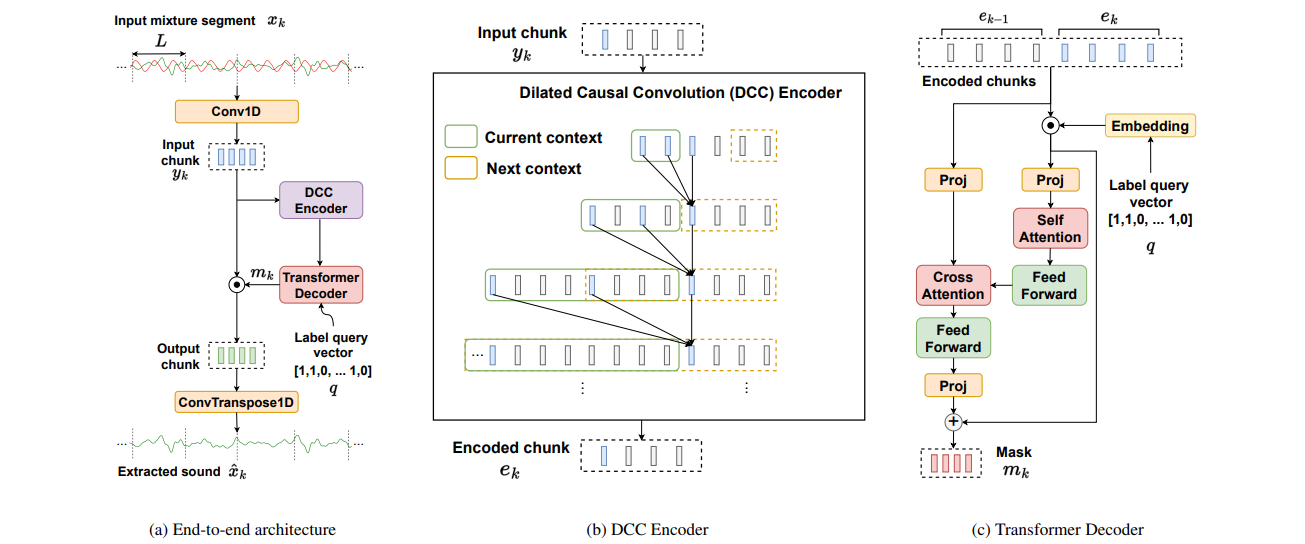

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torchaudio.transforms as T
import torchaudio
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics.functional import(
    scale_invariant_signal_noise_ratio as si_snr,
    signal_noise_ratio as snr,
    signal_distortion_ratio as sdr,
    scale_invariant_signal_distortion_ratio as si_sdr)

In [ ]:
path = "path_to_your_audio_file"


def split_audio(filename , t):
  waveform, sample_rate = torchaudio.load(filename)

  samples_per_chunk = int(t * sample_rate)

  num_chunks = waveform.shape[1] // samples_per_chunk

  chunks = []

  for i in range(num_chunks):
    start_sample = i * samples_per_chunk
    end_sample = start_sample + samples_per_chunk
    chunk = waveform[:, start_sample:end_sample]
    chunks.append(chunk)

  if waveform.size(1) % samples_per_chunk != 0:
        chunk = waveform[:, num_chunks * samples_per_chunk:]
        chunks.append(chunk)

  return chunks


chunks = split_audio(path, 1)

In [ ]:
chunks

In [ ]:
chunks_tensor = torch.stack(chunks)

chunks_tensor.shape

In [ ]:
t = chunks[0].shape[0]
sampling_rate = chunks[0].shape[1]
S = t * sampling_rate

# EACH AUDIO CHUNK XK IS OF DIMENSIONS R^S

In [ ]:
class LayerNormPermuted(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super(LayerNormPermuted, self).__init__(*args, **kwargs)

    def forward(self, x):
        """
        Args:
            x: [B, C, T]
        """
        x = x.permute(0, 2, 1) # [B, T, C]
        x = super().forward(x)
        x = x.permute(0, 2, 1) # [B, C, T]
        return x

In [ ]:
class DepthwiseSeparableConv(nn.Module):
    """
    Depthwise separable convolutions
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding, dilation):
        super(DepthwiseSeparableConv, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv1d(in_channels, in_channels, kernel_size, stride,
                      padding, groups=in_channels, dilation=dilation),
            LayerNormPermuted(in_channels),
            nn.ReLU(),
            nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1,
                      padding=0),
            LayerNormPermuted(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.layers(x)


from collections import OrderedDict


class DilatedConvEncoder(nn.Module):
    def __init__(self, channels, num_layers, kernel_size=3):
        super(DilatedConvEncoder, self).__init__()
        self.channels = channels
        self.num_layers = num_layers
        self.kernel_size = kernel_size

        assert kernel_size % 2 == 1, "Kernel size must be odd."

        # Dilated causal conv layers aggregate previous context to obtain
        # contexful encoded input.
        _dcc_layers = OrderedDict()
        for i in range(num_layers):
            dcc_layer = DepthwiseSeparableConv(
                channels, channels, kernel_size=3, stride=1,
                padding=(kernel_size // 2) * 2**i, dilation=2**i)
            _dcc_layers.update({'dcc_%d' % i: dcc_layer})
        self.dcc_layers = nn.Sequential(_dcc_layers)

    def forward(self, x):
        for layer in self.dcc_layers:
            x = x + layer(x)
        return x

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super(SelfAttention, self).__init__()
    assert embed_dim % num_heads == 0

    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.head_dim = embed_dim // num_heads

    self.query = nn.Linear(embed_dim, embed_dim)
    self.key = nn.Linear(embed_dim, embed_dim)
    self.value = nn.Linear(embed_dim, embed_dim)
    self.out = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    batch_size, seq_len, embed_dim = x.size()

    q = self.query(x)
    k = self.key(x)
    v = self.value(x)

    q = q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
    k = k.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
    v = v.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

    scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
    attention_weights = torch.softmax(scores, dim = -1)
    context = torch.matmul(attention_weights, v)

    context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_dim)

    out = self.out(context)

    return out, attention_weights

In [ ]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttention, self).__init__()
        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, query_seq, key_value_seq):
        batch_size, query_seq_length, embed_dim = query_seq.size()
        _, key_value_seq_length, _ = key_value_seq.size()

        Q = self.query(query_seq)
        K = self.key(key_value_seq)
        V = self.value(key_value_seq)

        Q = Q.view(batch_size, query_seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, key_value_seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, key_value_seq_length, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        attention_weights = torch.softmax(scores, dim=-1)
        context = torch.matmul(attention_weights, V)

        context = context.transpose(1, 2).contiguous().view(batch_size, query_seq_length, self.embed_dim)

        out = self.out(context)
        return out, attention_weights

In [ ]:
class ConvTranspose(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride):
    super(ConvTranspose, self).__init__()
    self.conv = nn.ConvTranspose1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)

  def forward(self, x):
    x = self.conv(x)

    return x

In [ ]:
class Net(nn.Module):
    def __init__(self, E, num_layers, D, L, label_len, num_heads):
        super(Net, self).__init__()
        self.conv = nn.Conv1d(in_channels = 1, out_channels = E, kernel_size = 3 * L, stride = L)
        self.DCCE = DilatedConvEncoder(channels = E, num_layers = 10)
        self.label_embedding = label_embedding = nn.Sequential(
            nn.Linear(label_len, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, E),
            nn.LayerNorm(E),
            nn.ReLU())

        self.proj_e2d_e = nn.Sequential(
                nn.Conv1d(in_channels = E, out_channels = D, kernel_size = 1, stride = 1, padding = 0),
                nn.ReLU())
        self.proj_d2e = nn.Sequential(
                nn.Conv1d(in_channels = D, out_channels = E, kernel_size = 1, stride = 1, padding = 0),
                nn.ReLU())
        self.self_attention = SelfAttention(embed_dim = D, num_heads = num_heads)

        self.cross_attention = CrossAttention(D, num_heads)

        self.ff = nn.Sequential(nn.Linear(D, D),nn.ReLU())

        self.ct = ConvTranspose(in_channels = E, out_channels = 1, kernel_size = 3*L,stride = L)

    def forward(self, x, label):
        latent_space_chunks = self.conv(x)

        encoded = self.DCCE(latent_space_chunks)

        l = self.label_embedding(label)

        l = l.unsqueeze(2)

        encoded_dash = l * encoded

        p_encoded = self.proj_e2d_e(encoded)
        p_encoded_d = self.proj_e2d_e(encoded_dash)

        p_encoded_d = p_encoded_d.permute(0, 2, 1)
        p_encoded_d, _ = self.self_attention(p_encoded_d)

        #p_encoded_d = p_encoded_d.permute(0,2,1)
        p_encoded_d = self.ff(p_encoded_d)

        p_encoded = p_encoded.permute(0,2,1)

        mask, _ = self.cross_attention(p_encoded,p_encoded_d)

        mask = self.ff(mask)
        mask = mask.permute(0, 2, 1)

        mask = self.proj_d2e(mask)
        mask = mask + encoded_dash

        latent_space_chunks = latent_space_chunks * mask

        out = self.ct(latent_space_chunks)

        return out

In [ ]:
def optimizer(model, data_parallel=False, **kwargs):
    return optim.Adam(model.parameters(), **kwargs)

def loss(pred, tgt):
    return -0.9 * snr(pred, tgt).mean() - 0.1 * si_snr(pred, tgt).mean()

def metrics(mixed, output, gt):
    """ Function to compute metrics """
    metrics = {}

    def metric_i(metric, src, pred, tgt):
        _vals = []
        for s, t, p in zip(src, tgt, pred):
            _vals.append((metric(p, t) - metric(s, t)).cpu().item())
        return _vals

    for m_fn in [snr, si_snr]:
        metrics[m_fn.__name__] = metric_i(m_fn,
                                          mixed[:, :gt.shape[1], :],
                                          output,
                                          gt)

    return metrics

In [ ]:
model = Net(256, 10, 128, 32, 2, 8)

In [ ]:
num_epochs = 80
criterion = loss
opt = optimizer(model, lr=0.05)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    # Forward pass
    outputs = model(chunks_tensor, one_hot_tensor)

    # Compute loss
    loss_value = criterion(outputs, chunks_tensor)

    # Backward pass and optimization
    opt.zero_grad()
    loss_value.backward()
    opt.step()

    # Print loss for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_value.item():.4f}')

print("Training complete.")

In [ ]:
import numpy as np
from IPython.display import Audio

for i, chunk in enumerate(outputs):
    # Convert the tensor to a NumPy array and ensure it's 1D
    audio_data = chunk.squeeze().detach().numpy()  # Assuming the chunk might have an extra dimension
    print(f"Playing chunk {i+1}")
    display(Audio(audio_data, rate=8000))